# **Определение возраста покупателей**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.  

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. Заказчик предоставил набор фотографий людей с указанием возраста.

# Гипотезы исследования и исследовательские вопросы

Главной **задачей** данного проекта стало построение модели машинного обучения для сетевого супермаркета "Хлеб-Соль", которая по фотографии определит приблизительный возраст человека. Модель поможет заказчику в организации предложений товаров их возрастной категории и осуществлять контроль за недобросовестными кассирами в вопросе продажи алкоголя несовершеннолетним.

Заказчик предоставил датасет с фотографиями людей: [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/)

В данном датасете две колонки:  
- file_name - название фотографии  
- real_age - реальный возраст человека на фотографии (целевой признак)

## Исследовательский анализ данных

Сперва я импортирую все необходимые для дальнейшей работы библиотеки:

In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

!pip install tensorflow --ignore-installed
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam

  Using cached tensorflow-2.18.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached packaging-24.1-py3-none-any.whl.metadata (3.2 kB)
  Using cached protobuf-5.28.3-cp38-abi3-macosx_10_9_universal2.whl.metadata (592 bytes)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached setuptools-75.3.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

Далее следует ознакомиться с данными поближе.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
data.shape

(7591, 2)

In [5]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
data.duplicated().sum()

0

**Вывод:** таким образом, было обнаружено, что нет необходимости менять тип данных, нахвание столбцов, а также отсутствуют пропуски и дубликаты. 

**Размер выборки:** 7591 фотографии

Далее следует рассмотреть распределение возраста в выборке. Сначала стоит рассмотреть топ-10 самых частых возрастов

In [7]:
data['real_age'].value_counts().head(10)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
Name: real_age, dtype: int64

In [8]:
data['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Далее следует визуализировать возрастное распределение

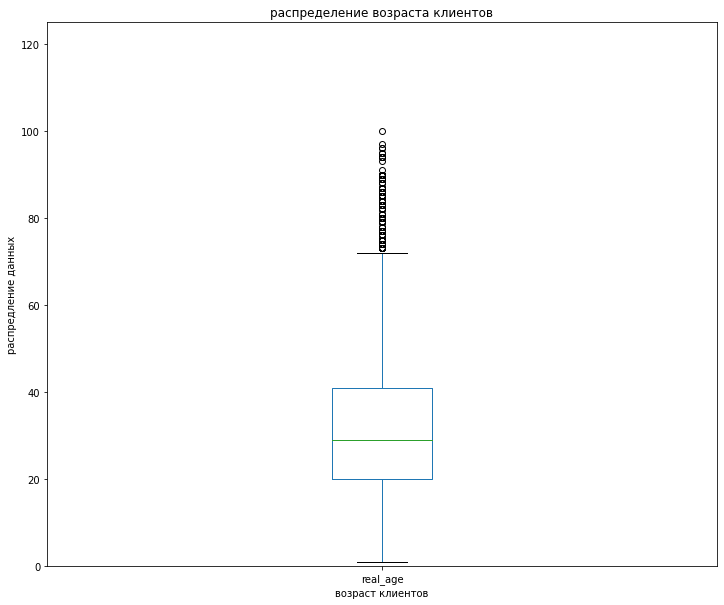

In [9]:
data['real_age'].plot(kind='box', figsize=(12, 10))
plt.ylim (0, 125)

plt.ylabel('распредление данных')
plt.xlabel('возраст клиентов')
plt.title('распределение возраста клиентов')
plt.show()

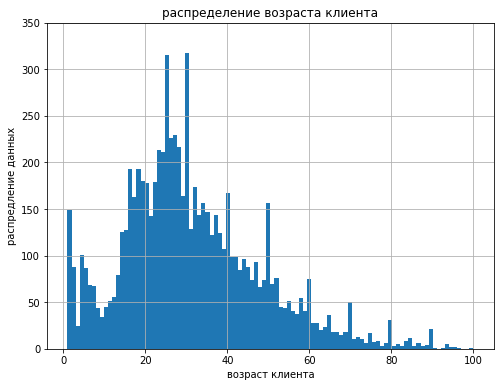

In [10]:
data['real_age'].hist(bins=100, figsize=(8, 6))
plt.ylim (0, 350)

plt.ylabel('распредление данных')
plt.xlabel('возраст клиента')
plt.title('распределение возраста клиента')
plt.show()

**Вывод:** в выборке представлен возрастной диапазон от 0 до 100 лет. Как можно заметить и при вызове метода value_counts(), и при анализе визуализации, чаще других на фотографиях изображены люди примерно от 20 до 30 (также присутствуют пики 30 и 25 лет). Также можно заметить, что среди детского возраста чаще встречаются младенцы до года. Важно отметить, что почти у всех начал декад присутствуют пиковые значения, по сравнению с остальным периодом этой декады. На графике "ящика с усами" можно увидеть выбросы после 70 лет (примерно), однако, я не считаю рациональным сокразать выборку, поскольку люди после этого возраста не являются аномалиями (опираясь на критическое мышление)

Выраженная частота фотографий с молодыми людими от 20 до 30 и "юбиляров" может сказаться на предсказаниях модели.

Далее стоит загрузить выборки с помощью метода flow_from_dataframe

In [11]:
data_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
train_gen_flow = data_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=43)

val_gen_flow = data_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=43)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


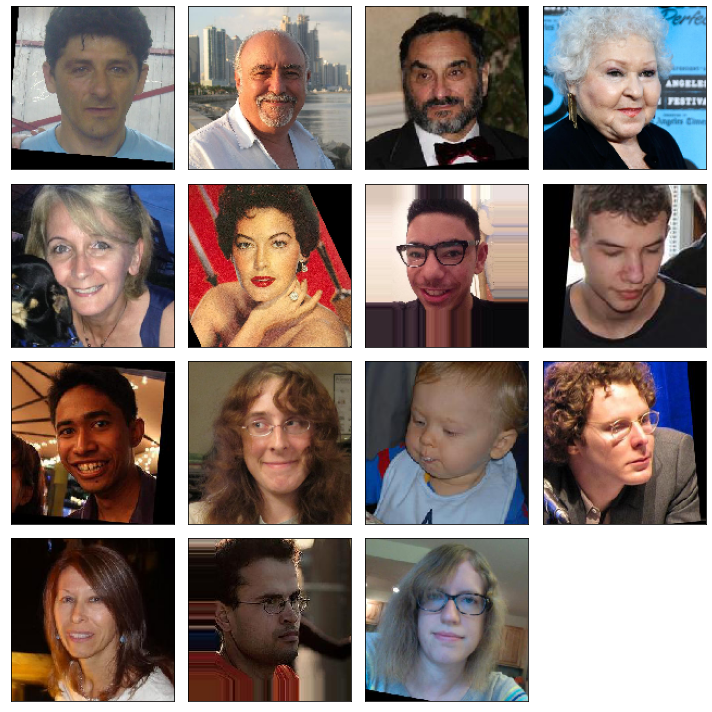

In [14]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Если ознакомиться с фотографиями, то можно заметить, что они прошли некоторую предобработку - лица более-менее выровнены (расположены вертикально), где-то обработан фон, чтобы было лучше видно лицо. Однако, далеко не все фотографии имеют нейтральный фон и очищены от посторонних деталей (на одной из фотографий рядом с лицом женщины собака) для лучшей детекции лица, что может сказаться на качестве предсказания модели.  

В идеальных условиях я бы провела сегментацию изображений, чтобы точно выделить лицо, однако, ввиду ограниченности теории по данной теме в ЯП, оставлю это до лучших времен.

**Вывод по данному разделу:** по результатам исследования данных в количестве 7591 фотографий людей, на качество предсказания могут повлиять:
- частота фотографий молодых людей от 20 до 30  
- частота фотографий людей с круглыми датами (круглых юбиляров) по сравнению с остальным периодом декады. 
- наличие иных деталей на фоне фотографии, что создает некоторых "информационный шум"  
- разные ракурсы съемки


Ради решения данных проблем, можно было бы добавить детских фотографий до 15-17 лет, добавить фотографий иных возрастов после 40, а также провести более тщательную предобработку фотографий с учетом вышеупомянутых ограничений.

## Обучение модели

Для задачи регрессии была выбрана модель ResNet50 с одним нейроном в виду лучших показателей MAE. Модель предобучилась на данных 'imagenet'. Обучение происходило в 20 эпох, алгоритмом Adam и lr=0.00001. В качестве метрики качества использовалась метрика MAE.

```python

import pandas as pd
import numpy as np

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.metrics import MeanAbsoluteError


def load_train(path):

    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale = 1/255.)
    train_data = train_datagen.flow_from_dataframe(
        dataframe = labels, 
        directory = path + 'final_files/', 
        x_col='file_name', y_col='real_age', 
        subset = 'training', 
        target_size = (150, 150), 
        batch_size = 16, 
        class_mode='raw', 
        seed=12345)

    return train_data

def load_test(path):

    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale = 1/255.)
    test_data = test_datagen.flow_from_dataframe(
        dataframe = labels, 
        directory = path + 'final_files/', 
        x_col='file_name', y_col='real_age', 
        subset = 'validation', 
        target_size = (150, 150), 
        batch_size = 16, 
        class_mode='raw', 
        seed=12345)

    return test_data

def create_model(input_shape):

    optimizer = Adam(lr=0.00001)
    backbone=ResNet50(input_shape=input_shape, weights = 'imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20, 
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, validation_data=test_data, steps_per_epoch=steps_per_epoch, 
              validation_steps = validation_steps,
             verbose=1, epochs=epochs, batch_size=batch_size)
    return model

```

119/119 - 9s - loss: 87.7421 - mae: 7.2186
Test MAE: 7.2186

В рамках данного проекта было получено финальное значение метрики MAE - 7.2186, что удовлетворяет поставленной задаче всего проекта. При анализе всех эпох не было обнаружено переобучения.

## Анализ обученной модели

Исходные данные содержат 7591 фотографию человеческих лиц, без пропусков и дубликатов. Возрастное определение оказалось не совсем нормальным, есть 2 пиковых значения 25 и 30 лет,а также на каждой круглой дате. Кроме того, качество предобработки фотографий имеет некоторые ограничения, например, разные ракурсы лица, наличие необработанного фона и деталей непосредственно рядом с лицом. Данные ограничения в возрастной выборке и предобработке фото могли повлиять на качество предсказаний.

После обучения модели ResNet50 для задачи регрессии (предсказание возраста), было получено значение MAE на тестовой выборке 7.2186. Это означает, что модель ошибается примерно на 7 лет. 

Для улучшения качества модели, можно изменить некоторые параметры в обучении, увеличить число фотографий некоторых возрастов, для более нормального распределения, а также улучшить качество предобработки фона. Однако, данное значение приемлемо для данного проекта